<div align="center">

# Computer Vision Project: Sudoku
## University of Pavia - 2023/24
### Fabio Zamboni
### Federico Pietro Bernardini

</div>

# Sudoku number extraction

In this notebook we will use computer vision techniques to extract the numbers from a sudoku grid. We will use the following steps:


0. Generate a Sudoku Puzzles
1. Load the image   
2. Grid detection
3. Gray scale conversion
4. Blurring
5. Thresholding
6. Erosion
7. Contour detection
8. Number extraction (using PyTesseract)



<div align="center">

<img src="sudoku.png" style="padding: 40px;" />
<img src="sudoku_recognized.png" style="padding: 40px;" />

</div>

In [18]:
import cv2
import pytesseract as tess
import matplotlib.pyplot as plt
import numpy as np
from sudoku import Sudoku
from PIL import Image, ImageDraw, ImageFont

# Generate a Sudoku Puzzles

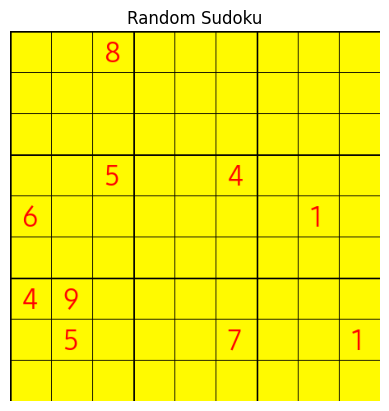

In [19]:
game = Sudoku(3).solve()

# Convert the board to a numpy array
sudoku = np.array(game.board)

# Remove some numbers from the solution to create a puzzle
for _ in range(71):
    while True:
        i, j = np.random.randint(0, 9, size=2)
        if sudoku[i, j] != 0:
            sudoku[i, j] = 0
            break

# Create a new image with a white background
img = Image.new('RGB', (450, 450), color = (255, 250, 0))

# Create a drawing object
d = ImageDraw.Draw(img)

# Draw a grid
for i in range(10):
    if i % 3 == 0:
        d.line([(i*50, 0), (i*50, 450)], fill=(0,0,0), width=2)
        d.line([(0, i*50), (450, i*50)], fill=(0,0,0), width=2)
    else:
        d.line([(i*50, 0), (i*50, 450)], fill=(0,0,0), width=1)
        d.line([(0, i*50), (450, i*50)], fill=(0,0,0), width=1)

# Load a font
fnt = ImageFont.truetype('~/Library/Fonts/174b2ec3d1b18323f2021ce3fdda6028.ttf', 35)

# Draw the numbers
for i in range(9):
    for j in range(9):
        if sudoku[i, j] != 0:
            d.text((j*50+15, i*50+5), str(sudoku[i, j]), font=fnt, fill=(255,0,0))

# Save the image
img.save('sudoku.png')
plt.imshow(img)
plt.axis('off')
plt.title('Random Sudoku')
plt.show()

# Load the image

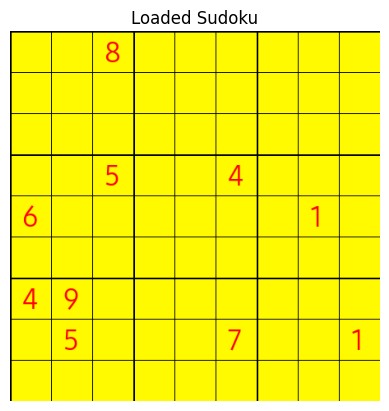

In [20]:
# Load the image
img = cv2.imread('sudoku.png')

# Show the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Loaded Sudoku')
plt.show()


# Grid detection

We will divide the image into 81 cells, each containing a number of the sudoku grid.

Number of cells: 81


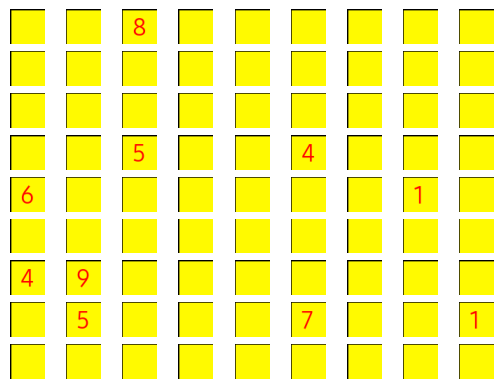

In [21]:
# Cut the image into 81 cells
cells = [np.hsplit(row, 9) for row in np.vsplit(img, 9)]
print('Number of cells:', len(cells)*len(cells[0]))

# Print all cells
for i in range(9):
    for j in range(9):
        plt.subplot(9, 9, i*9+j+1)
        plt.imshow(cv2.cvtColor(cells[i][j], cv2.COLOR_BGR2RGB))
        plt.axis('off')
plt.show()

# Gray scale conversion

We will convert the cells image to a gray scale cells image.

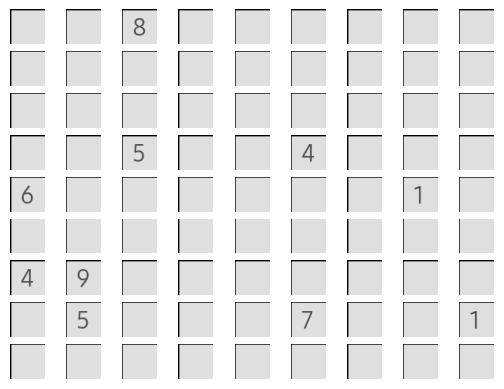

In [22]:
# Convert the cells to grayscale
gray_cells = np.zeros((9, 9), dtype=np.ndarray)

for i in range(9):
    for j in range(9):
        gray_cells[i][j] = cv2.cvtColor(cells[i][j], cv2.COLOR_BGR2GRAY)

# Print all cells
for i in range(9):
    for j in range(9):
        plt.subplot(9, 9, i*9+j+1)
        plt.imshow(cv2.cvtColor(gray_cells[i][j], cv2.COLOR_BGR2RGB))
        plt.axis('off')
plt.show()

# Blurring

We will apply a Gaussian blur to the cells image.

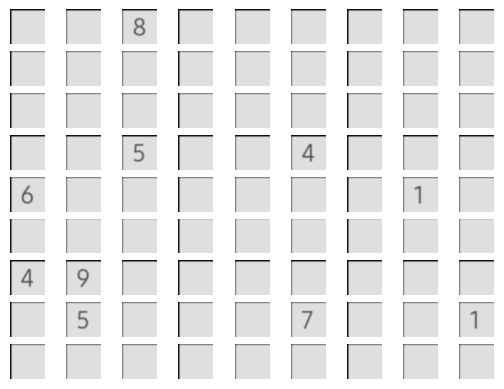

In [23]:
# Apply gaussian blur
blur_cells = np.zeros((9, 9), dtype=np.ndarray)

for i in range(9):
    for j in range(9):
        blur_cells[i][j] = cv2.GaussianBlur(gray_cells[i][j], (3, 3), 1)

# print all cells
for i in range(9):
    for j in range(9):
        plt.subplot(9, 9, i*9+j+1)
        plt.imshow(cv2.cvtColor(blur_cells[i][j], cv2.COLOR_BGR2RGB))
        plt.axis('off')

# Thresholding

We will apply a threshold to the cells image.

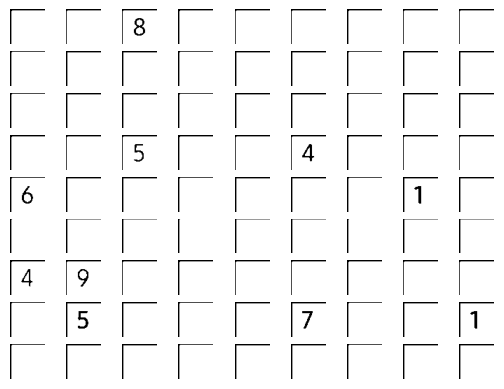

In [24]:
# apply threshold
thresh_cells = np.zeros((9, 9), dtype=np.ndarray)

for i in range(9):
    for j in range(9):
        thresh_cells[i][j] = cv2.threshold(blur_cells[i][j], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# print all cells
for i in range(9):
    for j in range(9):
        plt.subplot(9, 9, i*9+j+1)
        plt.imshow(cv2.cvtColor(thresh_cells[i][j], cv2.COLOR_BGR2RGB))
        plt.axis('off')
plt.show()


## Erosion

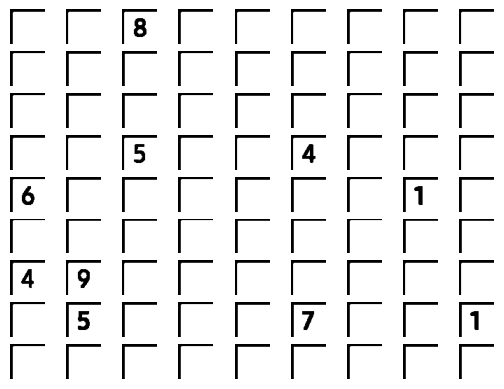

In [25]:
# apply dilation on the inverted image

erosion_cells = np.zeros((9, 9), dtype=np.ndarray)
inverted_cells = np.zeros((9, 9), dtype=np.ndarray)

for i in range(9):
    for j in range(9):
        kernel = np.ones((2, 2), np.uint8)
        erosion_cells[i][j] = cv2.erode(thresh_cells[i][j], kernel, iterations=2)


# print all cells
for i in range(9):
    for j in range(9):
        plt.subplot(9, 9, i*9+j+1)
        plt.imshow(cv2.cvtColor(erosion_cells[i][j], cv2.COLOR_BGR2RGB))
        plt.axis('off')
plt.show()

# Contour detection

We will detect the contours of the numbers in the thresholded cells image using the dilated image.

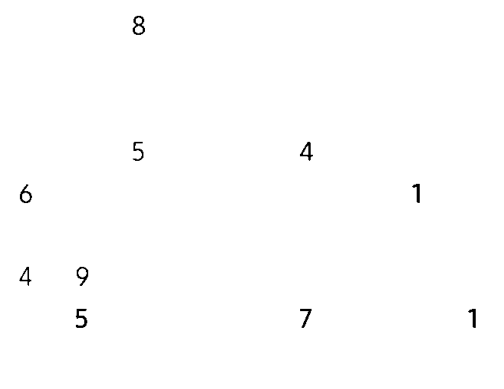

In [26]:
# find contours
contours_cells = np.zeros((9, 9), dtype=np.ndarray)
biggest_contours_cells = np.zeros((9, 9), dtype=np.ndarray)
digit_cells = np.zeros((9, 9), dtype=np.ndarray)

cells_copy = thresh_cells.copy()

for i in range(9):
    for j in range(9):
        contours_cells[i][j], _ = cv2.findContours(erosion_cells[i][j], cv2.CONTOURS_MATCH_I1, cv2.CHAIN_APPROX_NONE)
        #contours_cells[i][j], _ = cv2.findContours(dilated_cells[i][j], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for i in range(9):
    for j in range(9):
        if len(contours_cells[i][j]) > 0:
            biggest_contours_cells[i][j] = max(contours_cells[i][j], key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(biggest_contours_cells[i][j])
            #digit_cells[i][j] = cells_copy[i][j][int(y*0.6):y+int(h*1.4), int(x*0.6):x+int(w*1.4)]
            digit_cells[i][j] = cells_copy[i][j][y:y+h, x:x+w]

for i in range(9):
    for j in range(9):
        plt.subplot(9, 9, i*9+j+1)
        plt.imshow(cv2.cvtColor(digit_cells[i][j], cv2.COLOR_BGR2RGB))
        plt.axis('off')
plt.show()

# Number extraction (using PyTesseract)

In [27]:
# pytesseract
tess_cells = np.zeros((9, 9), dtype=np.ndarray)

for i in range(9):
    for j in range(9):
        tess_cells[i][j] = tess.image_to_string(cv2.cvtColor(digit_cells[i][j], cv2.COLOR_BGR2RGB), config='--psm 10 --oem 3 -c tessedit_char_whitelist=123456789')

print('Tesseract output:')
print(tess_cells)


Tesseract output:
[['' '' '8\n' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '']
 ['' '' '5\n' '' '' '4\n' '' '' '']
 ['6\n' '' '' '' '' '' '' '1\n' '']
 ['' '' '' '' '' '' '' '' '']
 ['4\n' '9\n' '' '' '' '' '' '' '']
 ['' '5\n' '' '' '' '7\n' '' '' '1\n']
 ['' '' '' '' '' '' '' '' '']]


## Final Image

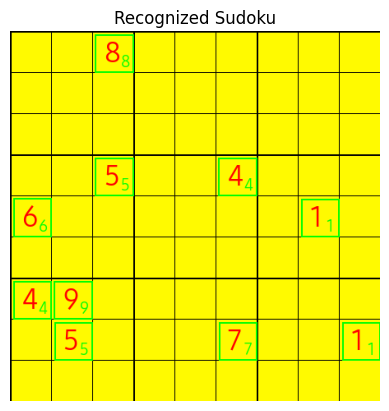

In [28]:
img_rc = Image.fromarray(cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB), 'RGB')

# Create a drawing object
d = ImageDraw.Draw(img_rc)

# Load a font
fnt = ImageFont.truetype('~/Library/Fonts/174b2ec3d1b18323f2021ce3fdda6028.ttf', 20)
for i in range(9):
    for j in range(9):
        if tess_cells[i][j] != '':
            x, y, w, h = cv2.boundingRect(biggest_contours_cells[i][j])
            d.rectangle([(j*50+x, i*50+y), (j*50+x+w, i*50+y+h)], outline=(0,255,0), width=2)
            d.text((j*50+35, i*50+25), tess_cells[i][j], font=fnt, fill=(0,255,0))

# Save the image
img_rc.save('sudoku_recognized.png')
plt.imshow(img_rc)
plt.axis('off')
plt.title('Recognized Sudoku')
plt.show()



